In [31]:
import numpy as np 
import matplotlib.pyplot as plt
import torch as torch

# Automatic Differentiation

A brief informal introduction to automatic differentiation.

A Neural Network is a function implemented using a composition of small functions. The building blocks of Neural Networks are linear projections and non linear activation functions.

How do we compute the derivative a composite function? Using the chain rule. What pytorch, tensorflow or Jax does is computing this derivatives for any function we specify. So our task is:

1. Specify the function
2. Tell pytorch which derivatives do we want to obtain.

## Basic function

Let's start with the function:

$$
y = (x^2 - 4)^3 + 2
$$

The derivative is

$$
\frac{\partial y}{\partial x} = \text{...}
$$

something we usually derive implicitely using our knowledge of basic derivatives, such that the derivative of $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$. 

However, when things get complicate we need to specify a way to obtain complex derivatives, and this is where the chain rule comes into place. For functions $f:\mathbb{R} \rightarrow \mathbb{R}$, we can use the one-dimensional chain rule. 

The idea of the chain rule is to express functions as composition of elementary functions from which the derivative is well known. In our example we could break into a small composition of functions.

$$
y = (x^2 - 4)^3 + 2
$$

could be written as:

$$
\begin{split}
t = \text{...}\\
u = \text{...}\\
z = \text{...}\\
y = \text{...} 
\end{split}
$$

Let's start substituting to show it is equivalent. First subsitute $z = \text{...}$ into $y = \text{...}$, yielding $y = \text{...}$. Now do the same thing and substitute $u = \text{...}$ into $y = \text{...}$, yielding: $y = \text{...}$, and finally subsitute  $t = \text{...}$ into  $y = \text{...}$ yielding $y = ( x^2 - 4)^3 + 2$, which is our original function.

When broken into small functions, we know that the full derivative can be obtained by multiplying the derivatives of the individual functions. In other words:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x}
$$

Obviously, the derivative of these small functions are usually easier and well known. In fact, the most important thing is that this gives a principle way of obtaining complex derivatives in a structured and well-ordered way. In fact, in this example when you applied the rule $f(x)^{n}$ is $f(x)^{n-1} \cdot f'(x)$, to obtain $\frac{\partial y}{\partial x}$ directly, you are implicitely applying the chain rule without noticing it.

Let's do it:

$$
\begin{split}
\frac{\partial y}{\partial z} = \text{...} \\
\frac{\partial z}{\partial u} = \text{...} \\
\frac{\partial u}{\partial t} = \text{...} \\
\frac{\partial t}{\partial x} = \text{...} \\
\end{split}
$$

So applying chain rule we have:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = \text{...}
$$

Note that the last is step is to actually have a derivative which is a function of $x$. In other words, we need to replace the value of $u$ in this example. So using a similar proceedure as above we know the steps to perform are:
1. substitute $t = \text{...}$ into $u = \text{...}$ to yield $u = \text{...}$, finishing the subsitution.
2. If we place this result back into the derivative, subsituting $u$ by this expression that depends on $x$ we yield:

$$
\frac{\partial y}{\partial x} = \frac{\partial y}{\partial z}\frac{\partial z}{\partial u}\frac{\partial u}{\partial t}\frac{\partial t}{\partial x} = \text{...} = 3(x^2 - 4)^2 \cdot 2x
$$

which happily matches the original derivative we obtained. For multivariate functions $f:\mathbb{R}^n \rightarrow \mathbb{R}^m$, things change a bit but that is a story for another chapter.

## Programming derivatives (numpy)

We can code up this example using numpy, where we code up both forward and backward computational graphs. The forward computational graph is refered to the set of operations that provide $y$ from $x$, i.e. the funciton $y(x) = (x^2 - 4)^3 + 2$, while the backward computatinoal graph is the derivative of $y$ w.r.t $x$, i.e. the function $\frac{\partial y}{\partial x} =  3 \cdot (x^2 - 4)^2 \cdot 2 x$. Both computatinoal graphs can be obtained directly or using chain rule.

Implement these computational graphs:

In [27]:
def y_of_x(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = (x**2 - 4)**3 + 2
    return y

def y_of_x_from_compositions(x: np.array):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments.

    Using the following composition of functions.

    $$
    \begin{split}
    \text{...}
    \end{split}
    $$
    
    """
    t = x**2
    u = t - 4
    z = u**3 
    y = z + 2
    return y


def partial_y_partial_x(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    dy_dx = 3 * (x**2 - 4)**2 * 2 * x   
    return dy_dx

def partial_y_partial_x_chain_rule(x : np.array):
    """Evaluates the derivative of $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments, using chain rule.
    
    To do so we use composition:

    $$
    \begin{split}
    t = \text{...} \\
    u = \text{...} \\
    z = \text{...} \\
    y = \text{...}
    \end{split}
    $$

    using partial derivatives:

    $$
    \begin{split}
    \frac{\partial y}{\partial z} = \text{...}
    \frac{\partial z}{\partial u} = \text{...}
    \frac{\partial u}{\partial t} = \text{...}
    \frac{\partial t}{\partial x} = \text{...}
    \end{split}
    $$
    """
    # we need to go through the function computation, (i.e forward operation) to obtain derivative using chain rule, so that 
    # we can replace u in the derivative.
    t = x**2
    u = t - 4
    z = u**3
    y = z + 2
    
    dt_dx = 2*x
    du_dt = 1
    dz_du = 3*(u**2)
    dy_dz = 1

    
    dy_dx = dy_dz * dz_du * du_dt * dt_dx
    
    return dy_dx

<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
<>:14: SyntaxWarning: invalid escape sequence '\e'
<>:41: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Jaime Cremades\AppData\Local\Temp\ipykernel_10224\4270913005.py:14: SyntaxWarning: invalid escape sequence '\e'
  \end{split}
C:\Users\Jaime Cremades\AppData\Local\Temp\ipykernel_10224\4270913005.py:41: SyntaxWarning: invalid escape sequence '\e'
  \end{split}


Once the above functions are implemented complete the following code:

Text(0.5, 0.98, 'Using Chain Rule')

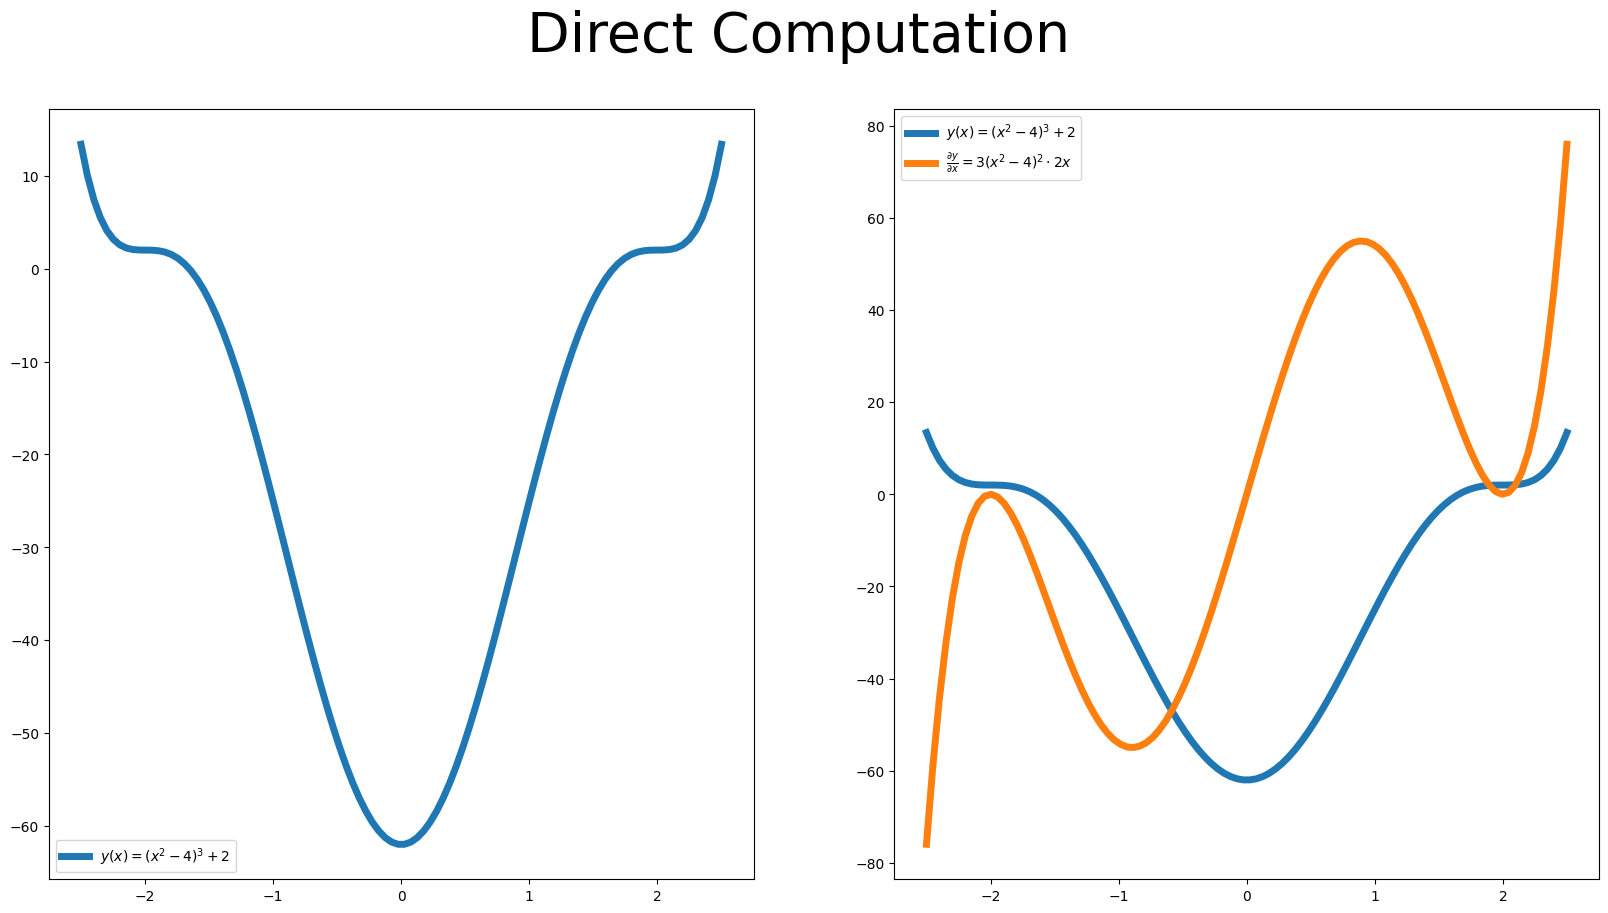

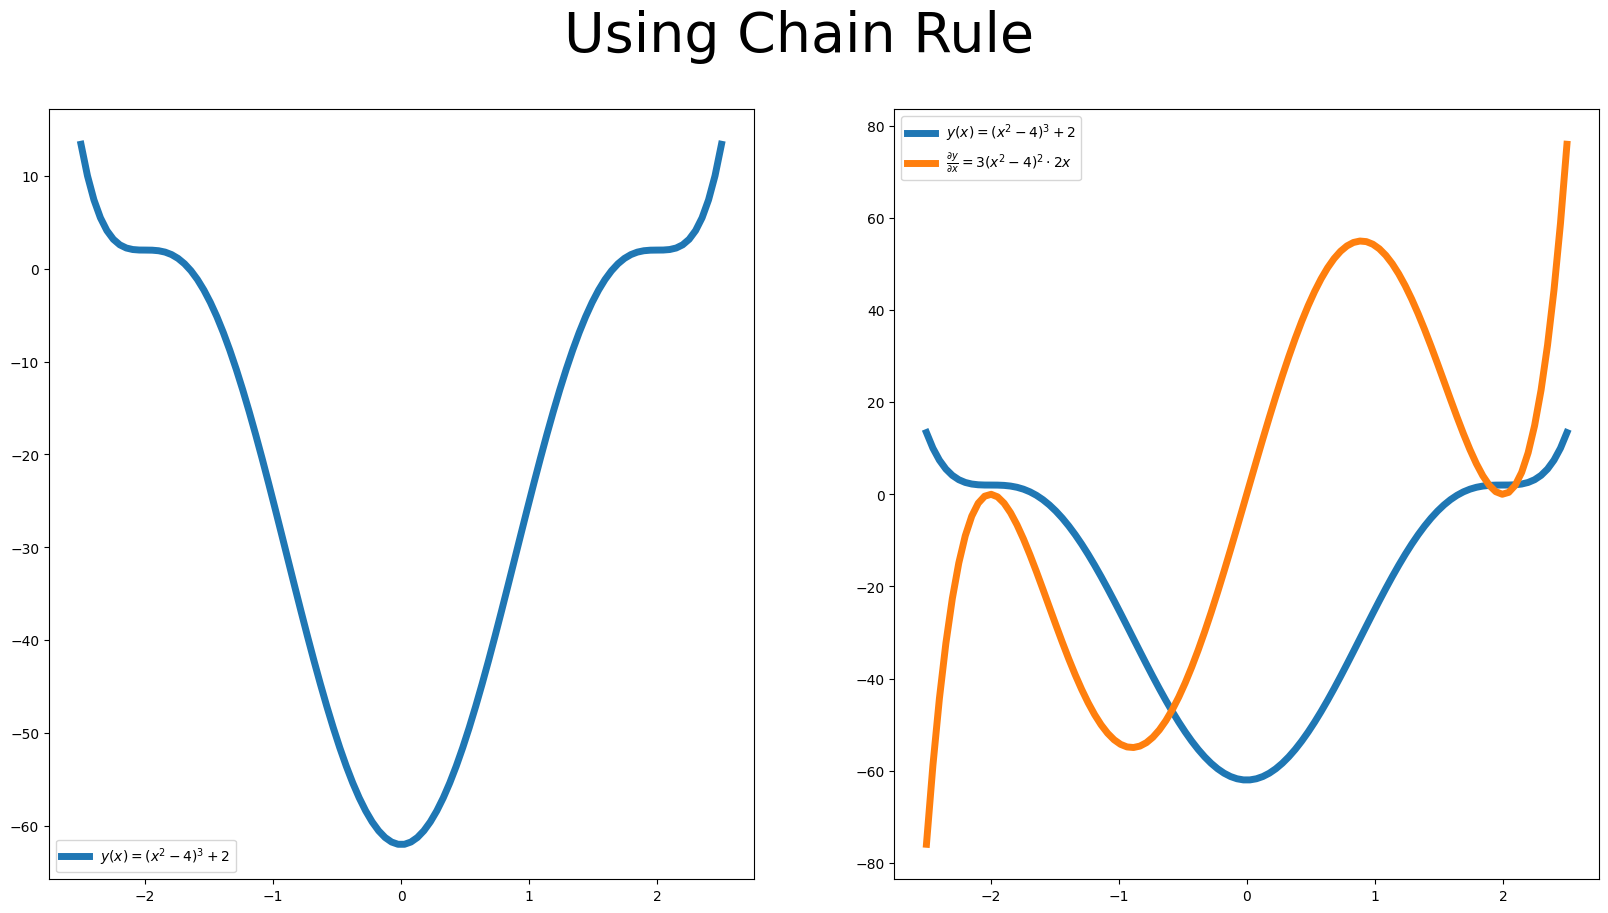

In [32]:
## range over which we want to plot the function
x_min = -2.5
x_max = 2.5
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## Using direct computation
y = y_of_x(x)
dy_dx = partial_y_partial_x(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Direct Computation", fontsize = 40)

## Using composition of functions and chain rule
y = y_of_x(x)
dy_dx = partial_y_partial_x_chain_rule(x)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,y, label = '$y(x) = (x^2 - 4)^3 + 2$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x} = 3(x^2 - 4)^2 \cdot 2x$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Using Chain Rule", fontsize = 40)

## Programming derivatives (torch / tensorflow / jax)

What advanced machine learning tools such as torch do to is compute the backward computational graph, from the forward computational graph provide by the user. In other words, tell pytorch which is your target function $y(x)$, through operations, and pytorch will obtain the derivatives automatically, no matter how complex the functions are.

Interestingly, you will notice that the python code is very similar to that used in numpy. The only requirement is to use torch tensors. We also need to tell torch what variables we want the gradient from. 

Complete the following code:

Text(0.5, 0.98, 'Computation with Automatic Differentiation')

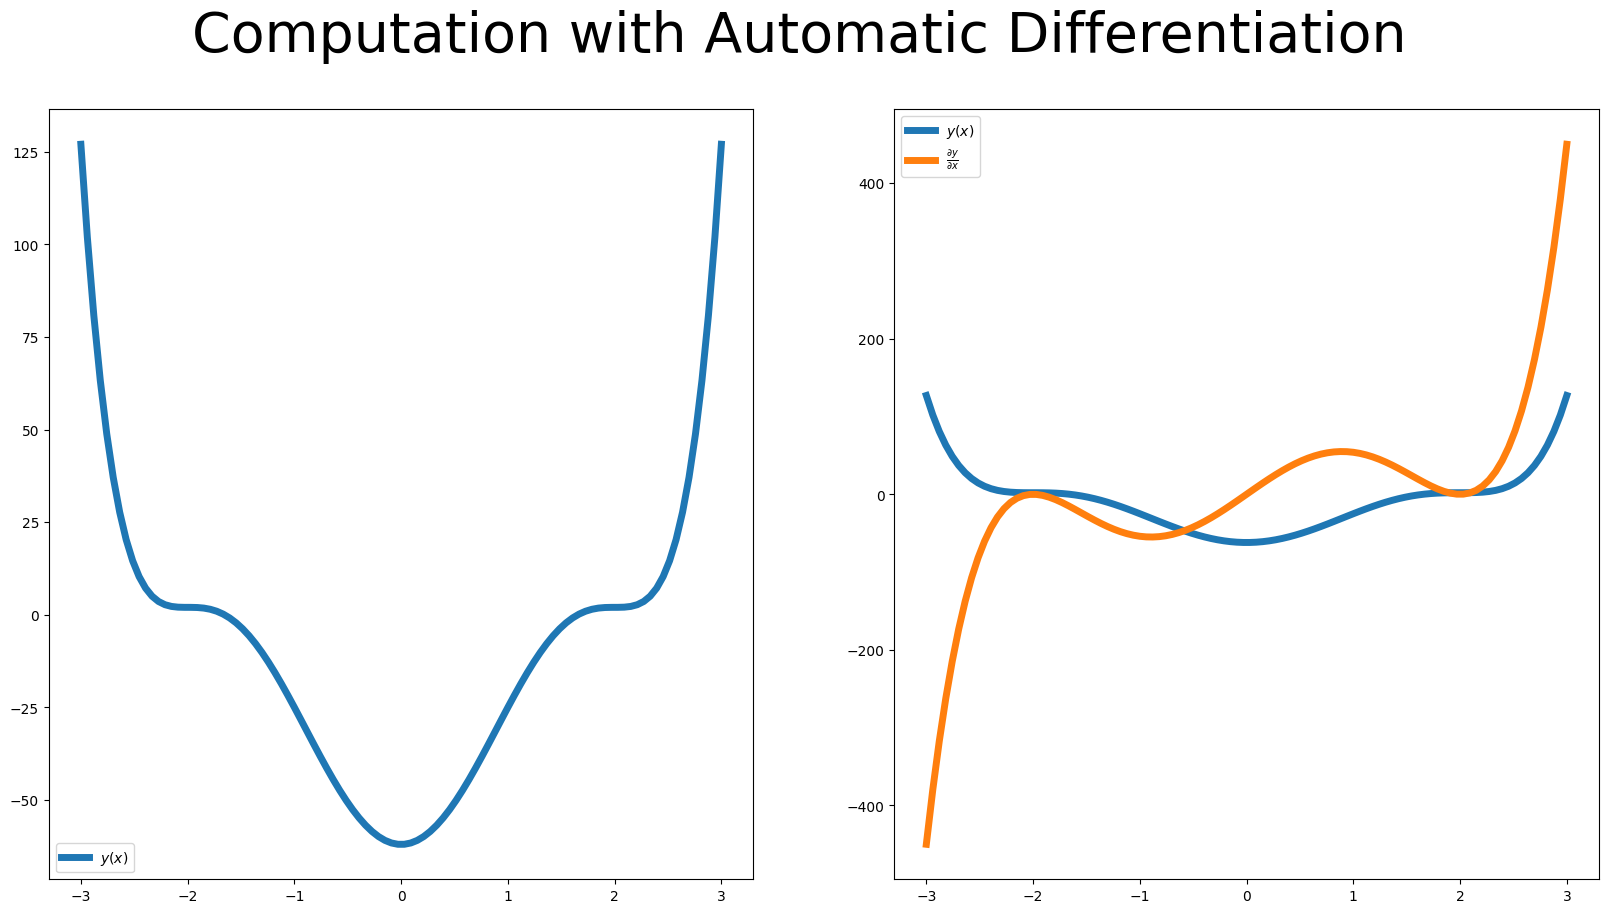

In [35]:
def y_of_x_torch(x : torch.tensor):
    """Evaluates the function $y = (x^2 - 4)^3 + 2$ at point x provided as input arguments."""
    y = y_of_x(x)
    return y

## with pytorch we can create the associated gradient function by just specifying the computational_graph. This tell us
#  pytorch to provide a funciton that obtains the grad of y_of_x(x) wrt x. Forget about vmap and grad, they are advanced 
#  functions you wont use yet but are useful to me to show what I want to show.
dy_dx_fun = torch.func.vmap( torch.func.grad(y_of_x_torch, argnums = 0) )

## range over which we want to plot the function
x_min = -3
x_max = 3
N_points = 100

x = np.linspace(x_min,x_max,N_points)

## conver to torch tensor.
x = torch.from_numpy(x)
## Tell pytorch this tensor requires grad so gradient is saved
x.requires_grad = True

## Forward operation: compute y(x)
y = y_of_x(x)

## Backward operation: evaluate the gradient function
dy_dx = dy_dx_fun(x)

## Convert back to numpy vectors. We use detach since vectors require gradients
x = x.detach().numpy()
y = y.detach().numpy()
dy_dx = dy_dx.detach().numpy()

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,10))

ax1.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x,y, label = '$y(x)$', linewidth = 5)
ax2.plot(x,dy_dx, label = r'$\frac{\partial y}{\partial x}$', linewidth = 5)
ax1.legend()
ax2.legend()
plt.suptitle("Computation with Automatic Differentiation", fontsize = 40)

Obviously, the result is the same as when you computed the derivatives manually. The good point is that now you can change the computational graph as you want, and the way we compute the derivative is let to pytorch. Try and change the computational graph specified by function: 